In [2]:
import cv2
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import feature
plt.rcParams['figure.dpi'] = 150
import pandas as pd

In [3]:
from seals_utils import show_img

In [5]:
def get_box(c,img,size:int):
    try:
        plt.figure()
        y,x = int(c[0]), int(c[1])
        #print(x,y)
        #width, height of bbox
        width=int(size*0.5)
        height=int(size*0.5)
        #retrieve chip of blob

        chip = img[x-width:x+width, y-height:y+height]

        #chip = cv2.cvtColor(chip, cv2.COLOR_BGR2RGB)
        plt.imshow(chip)
        
    except Exception as e:
        print(e)
        
    return #chip

In [6]:
def get_chip(c,img,size:int):
    try:
        #plt.figure()
        y,x = int(c[0]), int(c[1])
        #print(x,y)
        #width, height of bbox
        width=int(size*0.5)
        height=int(size*0.5)
        #retrieve chip of blob

        chip = img[x-width:x+width, y-height:y+height]

        #chip = cv2.cvtColor(chip, cv2.COLOR_BGR2RGB)
        #plt.imshow(chip)
        
    except Exception as e:
        print(e)
        
    return chip

In [7]:
def eval_chip_size(lion_type:str, chip_size:int):

    fig = plt.figure(figsize=(12,12))
    num_chips = len(coordinates_df[lion_type][0])
    try:
        for i in range(len(coordinates_df[lion_type][0])):
            ax = fig.add_subplot(num_chips/10+1,10,i+1)
            plt.xticks([]), plt.yticks([])
            plt.imshow(get_chip(coordinates_df[lion_type][0][i], image_2, chip_size))
    except ValueError:
        pass

In [8]:
r = 0.4     #scale down
width = 100 #patch size 

In [9]:
# Establish locations of images
train_dotted_path = 'data\TrainSmall2\TrainDotted\\'
train_path = 'data\TrainSmall2\Train\\'

In [10]:
# read the Train and Train Dotted images
filename = '41.jpg'
image_1 = cv2.imread("data\TrainSmall2\TrainDotted/" + filename)
image_2 = cv2.imread("data\TrainSmall2\Train/" + filename)
img1 = cv2.GaussianBlur(image_1,(5,5),0)
cut = np.copy(image_2)

In [11]:
# absolute difference between Train and Train Dotted -- use to isolate dot locations
image_3 = cv2.absdiff(image_1,image_2)
mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
mask_1[mask_1 < 50] = 0
mask_1[mask_1 > 0] = 255
image_4 = cv2.bitwise_or(image_3, image_3, mask=mask_1)

In [12]:
#show_img('img3',image_3)

In [13]:
mask_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
#show_img('mask_1',mask_1)
mask_1.shape

(3328, 4992)

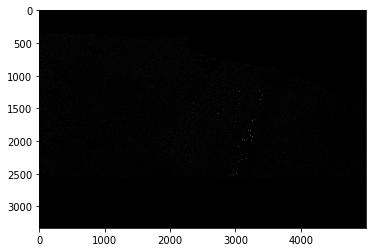

In [14]:
mask_1[mask_1 < 50] = 0
mask_1[mask_1 > 0] = 255
image_4 = cv2.bitwise_or(image_3, image_3, mask=mask_1)
plt.imshow(image_4)

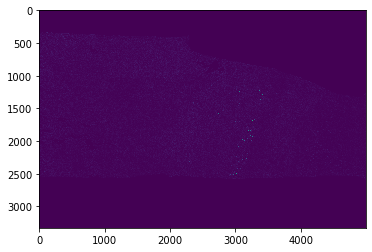

In [15]:
# convert to grayscale to be accepted by skimage.feature.blob_log
image_6 = np.max(image_4,axis=2)
plt.imshow(image_6)
#show_img('image_6',image_6)

In [16]:
# detect blobs
blobs = feature.blob_log(image_6, min_sigma=3, max_sigma=7, num_sigma=1, threshold=0.05)

h,w,d = image_2.shape # (3328, 4992, 3)

res=np.zeros((int((w*r)//width)+1,int((h*r)//width)+1,5), dtype='int16')

### Chipping method - https://www.kaggle.com/radustoicescu/count-the-sea-lions-in-the-first-image

In [17]:
import os

In [18]:
class_names = ['adult_females', 'adult_males', 'juveniles', 'pups', 'subadult_males']

file_names = os.listdir(r"data\TrainSmall2\Train")
file_names = sorted(file_names, key=lambda 
                    item: (int(item.partition('.')[0]) if item[0].isdigit() else float('inf'), item)) 

# select a subset of files to run on
file_names = file_names[0:1]

# dataframe to store results in
coordinates_df = pd.DataFrame(index=file_names, columns=class_names)

In [19]:
# initialize lists - we will append a coordinate pair each time we find a dot of one of these classes of sea lion
adult_males = []
subadult_males = []
pups = []
juveniles = []
adult_females = [] 

image_circles = np.copy(image_1)   # this copy will draw circles around the dots (colored by type)
image_rectangles = np.copy(image_2)   # this copy will draw rectangles around 

# half_size based on these:
# females - 75
# adult males - 120
# juveniles - 60
# pups - 40
# subadult_males - ?

# Loop through blobs - depending on type of sea lion type, mark them accordingly

for blob in blobs:
        # get the coordinates for each blob
        y, x, s = blob
        
        # get the color of the pixel from Train Dotted in the center of the blob
        b,g,R = image_1[int(y)][int(x)][:]
        
        #print(b,g,R)
        x1 = int((x*r)//width)
        y1 = int((y*r)//width)
        
        # decision tree to pick the class of the blob by looking at the color in Train Dotted
        # Adult males
        if  R > 200 and b < 50 and g < 50: 
            half_size=60
            adult_males.append((int(x),int(y)))
            cv2.circle(image_circles, (int(x),int(y)), 20, (0,0,255), 10) 
            
            #### Test drawing rectangle for masks #### 
            
            cv2.rectangle(image_rectangles, 
                          (int(x-half_size), int(y+half_size)),
                          (int(x+half_size), int(y-half_size)),
                          (0,0,255),
                          -2
                          
                         )
            
            #top left, bottom right # (x-width,y+height) (x+width,y-height)
            #### End rectangle code ####
            
        # Subadult males
        elif R > 200 and b > 200 and g < 50: # MAGENTA
            half_size=40
            subadult_males.append((int(x),int(y))) 
            cv2.circle(image_circles, (int(x),int(y)), 20, (250,10,250), 10)
            cv2.rectangle(image_rectangles, 
                          (int(x-half_size), int(y+half_size)),
                          (int(x+half_size), int(y-half_size)),
                          (0,0,255),
                          -2
                          
                         )
        
        # Pups
        elif R < 100 and b < 100 and 150 < g < 200: # GREEN
            half_size=20
            pups.append((int(x),int(y)))
            cv2.circle(image_circles, (int(x),int(y)), 20, (20,180,35), 10)
            cv2.rectangle(image_rectangles, 
                          (int(x-half_size), int(y+half_size)),
                          (int(x+half_size), int(y-half_size)),
                          (0,0,255),
                          -2
                          
                         )
        
        # Juveniles
        elif R < 100 and  100 < b and g < 100: # BLUE
            half_size=30
            juveniles.append((int(x),int(y))) 
            cv2.circle(image_circles, (int(x),int(y)), 20, (180,60,30), 10)
            cv2.rectangle(image_rectangles, 
                          (int(x-half_size), int(y+half_size)),
                          (int(x+half_size), int(y-half_size)),
                          (0,0,255),
                          -2
                          
                         )
        
        # Females
        elif R < 150 and b < 50 and g < 100:  # BROWN
            half_size=40
            adult_females.append((int(x),int(y)))
            cv2.circle(image_circles, (int(x),int(y)), 20, (0,42,84), 10)  
            cv2.rectangle(image_rectangles, 
                          (int(x-half_size), int(y+half_size)),
                          (int(x+half_size), int(y-half_size)),
                          (0,0,255),
                          -2
                          
                         )

        cv2.rectangle(cut, (int(x)-112,int(y)-112),(int(x)+112,int(y)+112), 0,-1)
        
        coordinates_df["adult_males"][filename] = adult_males
        coordinates_df["subadult_males"][filename] = subadult_males
        coordinates_df["adult_females"][filename] = adult_females
        coordinates_df["juveniles"][filename] = juveniles
        coordinates_df["pups"][filename] = pups#Ideal chip sizes:
# females - 75
# adult males - 120
# juveniles - 60
# pups - 40
# subadult_males - ?



#### Check gallery of chips to examine appropriateness of bounding box size.

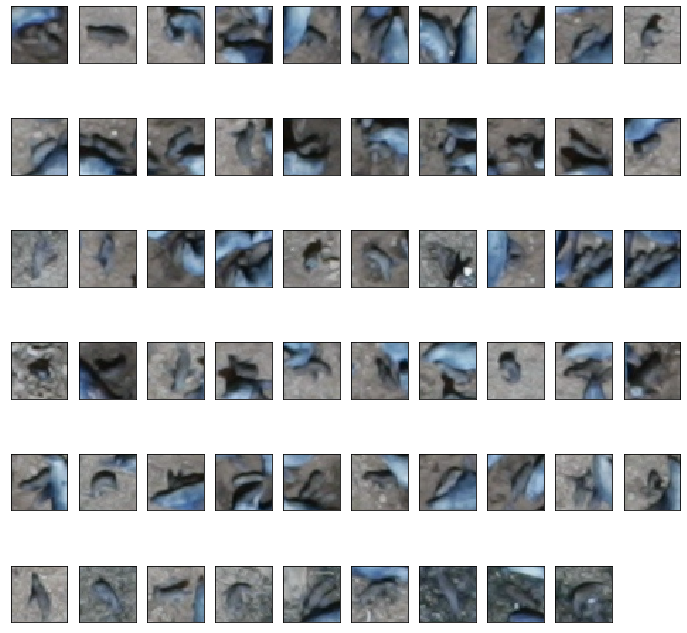

In [20]:
eval_chip_size('pups',40)

##### Rectangles drawn over only the dots - so some sea lions are not marked.

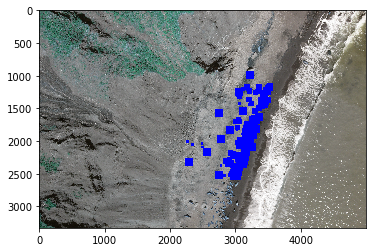

In [21]:
plt.imshow(image_rectangles)

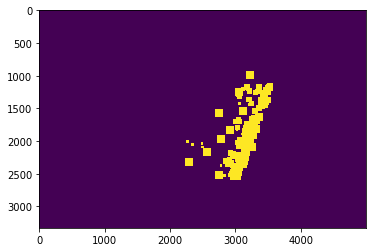

In [22]:
# Get inverse mask
rec_mask = cv2.inRange(image_rectangles, (0,0,254),(0,0,255))
plt.imshow(rec_mask)

In [23]:
final_mask = cv2.bitwise_and(image_2, image_2, mask=rec_mask)

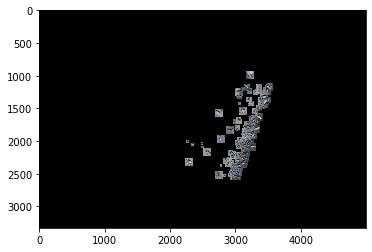

In [24]:
plt.imshow(final_mask)

In [25]:
coordinates_df.keys()
#Ideal chip sizes:
# females - 75
# adult males - 120
# juveniles - 60
# pups - 40
# subadult_males - ?

Index(['adult_females', 'adult_males', 'juveniles', 'pups', 'subadult_males'], dtype='object')

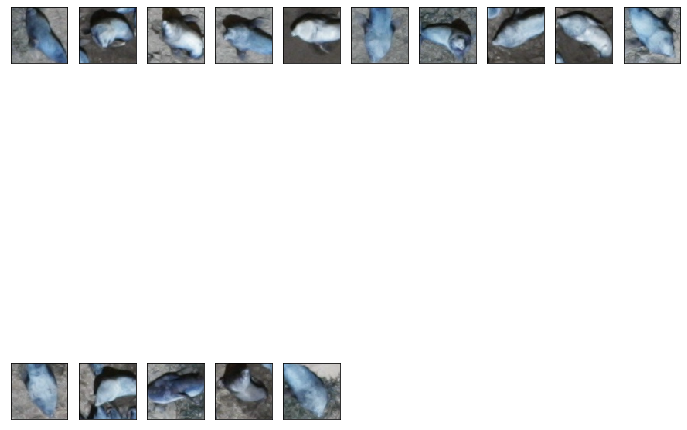

In [26]:
eval_chip_size('adult_males',75)

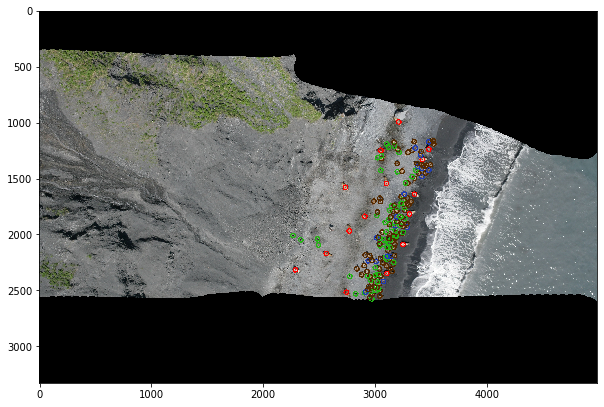

In [27]:
f, ax = plt.subplots(1,1,figsize=(10,16))
ax.imshow(cv2.cvtColor(image_circles, cv2.COLOR_BGR2RGB))
plt.show()
fixed = cv2.cvtColor(image_circles, cv2.COLOR_BGR2RGB)
#show_img('marked seals', fixed)